# HW 3 - Maci Simmons

In [3]:
import os
import os.path
import time
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import cvxpy as cp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
images_path = 'images/'

data_path = 'data/neural-nets/'

## Question 1: Orange vs. Blue Dots

**Summary**:  
Going epoch by epoch, the model first classifies everything as blue (Naive Bayes). Maybe there are slightly more blue dots than orange dots, so on the first pass, this is the best the model can do. The weights from each of the layers seem relatively equal; they're all close to the values they were initialized at. Around the 22nd epoch, the model splits the image into orange and blue with a plane (line) across the diagonal. The output neuron in the third layer corresponding to this diagonal split is receiving the most weight, so its classification receives the most weight. This is feeding from the bottom neuron in the hidden layer which corresponds to that diagonal split. Then, the "blue" area starts to take a round shape in the center of the image. The neuron corresponding to the diagonal split still has the most weight, but the other three neurons in the hidden layer create an overlap "blue" region that forms a round shape through the center and ends jsut before the "orange" region.  
Then, an important distinction happens. The neuron in the hidden layer that corresponds to the orange dots not only existing in the bottom right corner but also along the entire left side of the image begins to have a much higher weight. This isolates the "blue" region to the overlap of the blue regions in all of the hidden layer neurons, which is this oblong drop shape straight through the middle of the image. Most of the orange dots around the perimeter now exist in the "orange" region.  
Then, each of the four hidden layer neurons correponds to a different "orange" region in the perimeter -- the top left, top right, bottom left, and bottom right, respectively. Each of these classify all the dots in the middle as blue, and can agree on that, resulting in a correct classification of "blue" and "orange" regions. Of course, each neuron alone says that the split is diagonal, but the combination of them agrees most strongly that the center dots are blue and the perimeter dots are orange.

## Question 2: Activation Functions

This progression was similar to that of the tanh activation function, albeit a bit faster. I think the boundaries are linear because ReLU outputs the input value if it's positive, and zero if it's negative. This would result in a function that is linear for everything greater than zero.

## Question 3: Not finding global minimum

For some of the patterns, the algorithm would get stuck at a solution that was close but not quite right, and just stop improving from there. In that case, the gradients around this "local minimum" are such that the algorithm doesn't want to move outside of them to find a potentially lower minimum value, and takes the current solution to be the solution closest to the global minimum.

## Question 4: Too Small

The best thought process I have for this one is that there's not enough dimensionality/complexity to this network to find the true global minimum. It knows how to minimize across the dimensions it has, but doesn't have enough neurons to compute the gradient in the final direction. Especially for the image with the blue dots in the center and the orange dots in the perimeter; it needs that fourth neuron to capture all four sides of the perimeter, and without that, it gets stuck with a drop-like shape of blue region, unable to use gradient descent to categorize that final perimeter as orange.

## Question 5: Large Enough

There's enough neurons to keep track of more complex patterns, even in the spiral classification task. One neuron can handle a certain region, and there's enough conversation between neurons (one isn't weighted so slightly that it barely contributes) so that even neurons picking up on subtle patterns are able to contribute to the final decision. Even with only one hidden layer, when it has enough neurons (is "wide") enough, it's able to capture spatial relations very well.

## Question 6: Vanishing Gradient

It took over 200 epochs for the model to identify the correct shape/pattern, and even then it kept rapidly switching sizes of blue and orange regions and freaking out. I did also notice that the higher layers developed much more quickly -- I think this is because of the nature of backpropagation. The weight update from the highest layer is still large by the time it reaches the next hidden layer, but gets significantly smaller and thus doesn't update the lower layers much at all.

## Questions with Synthetic Data

**Generating Synthetic Data**:

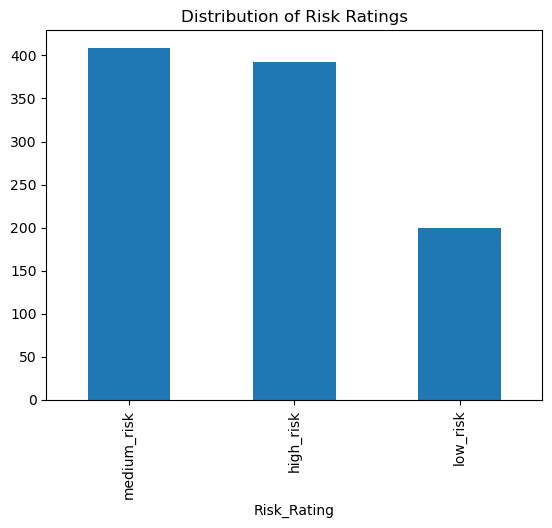

Risk_Rating
medium_risk    0.409
high_risk      0.392
low_risk       0.199
Name: count, dtype: float64


In [5]:
## RUN THIS CODE TO GENERATE THE SYNTHETIC DATA

np.random.seed(42)  # For reproducibility

n_samples = 1_000

# Generate synthetic features with noise
volatility = np.random.normal(1, 0.3, n_samples)
past_returns = np.random.normal(10, 5, n_samples)
market_cap = np.random.normal(200, 100, n_samples)
pe_ratio = np.random.normal(15, 10, n_samples)
# Introducing a new feature: interaction term (example: market cap * PE ratio)
interaction_term = market_cap * pe_ratio / 1000

# Initialize target labels array
labels = np.empty(n_samples, dtype=object)

# Define risk rating logic more clearly
for i in range(n_samples):
    # More nuanced conditions for risk categorization
    high_risk = (volatility[i] > 1.3) or (past_returns[i] < 5) or (pe_ratio[i] > 25)
    low_risk = (volatility[i] < 0.8) and (past_returns[i] > 15) or (market_cap[i] > 250)
    if high_risk:
        labels[i] = 'high_risk'
    elif low_risk:
        labels[i] = 'low_risk'
    else:
        labels[i] = 'medium_risk'

# Introduce noise by flipping labels for a small percentage of the dataset
noise_indices = np.random.choice(n_samples, size=int(n_samples * 0.05), replace=False)
for i in noise_indices:
    labels[i] = np.random.choice(['high_risk', 'medium_risk', 'low_risk'])

# Create and shuffle the DataFrame
data = pd.DataFrame({
    'Volatility': volatility,
    'Past_Returns': past_returns,
    'Market_Cap': market_cap,
    'PE_Ratio': pe_ratio,
    'Interaction_Term': interaction_term,  # New feature
    'Risk_Rating': labels
})

data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the data

# Visualize the distribution of risk ratings
data['Risk_Rating'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Ratings')
plt.show()

print(data['Risk_Rating'].value_counts() / n_samples)

#converting labels into classes
data['Risk_Rating'] = data['Risk_Rating'].map({'high_risk':0,'medium_risk': 1, 'low_risk': 2})

**Splitting Data:**

In [6]:
## RUN THIS CODE

# Split data into features and labels
X = data.drop("Risk_Rating", axis=1)
y = data["Risk_Rating"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Question 7

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4408 - loss: 0.9982 - val_accuracy: 0.6571 - val_loss: 0.7759
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6719 - loss: 0.7289 - val_accuracy: 0.7643 - val_loss: 0.6377
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7714 - loss: 0.6167 - val_accuracy: 0.7714 - val_loss: 0.5992
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.5765 - val_accuracy: 0.8143 - val_loss: 0.5789
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8294 - loss: 0.4921 - val_accuracy: 0.7857 - val_loss: 0.5125
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.4334 - val_accuracy: 0.8214 - val_loss: 0.5057
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8455 - loss: 0.4758 - val_accuracy: 0.8214 - val_loss: 0.4604
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8483 - loss: 0.3983 - val_accuracy: 0.8214 - val_loss

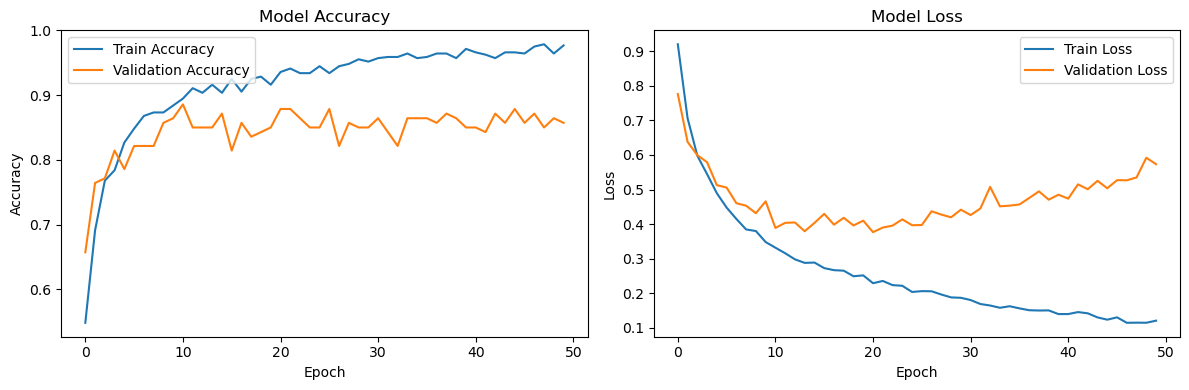

In [8]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50,validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100}%")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

# Loss plot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### Question 8 : tanh instead of ReLU

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5910 - loss: 0.8818 - val_accuracy: 0.6786 - val_loss: 0.7202
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6925 - loss: 0.7347 - val_accuracy: 0.6929 - val_loss: 0.6822
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7314 - loss: 0.6595 - val_accuracy: 0.7286 - val_loss: 0.6550
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7293 - loss: 0.6700 - val_accuracy: 0.7143 - val_loss: 0.6677
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7411 - loss: 0.6337 - val_accuracy: 0.7286 - val_loss: 0.6626
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7165 - loss: 0.6737 - val_accuracy: 0.7286 - val_loss: 0.6809
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7370 - loss: 0.6162 - val_accuracy: 0.7286 - val_loss: 0.6501
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7212 - loss: 0.6513 - val_accuracy: 0.6929 - 

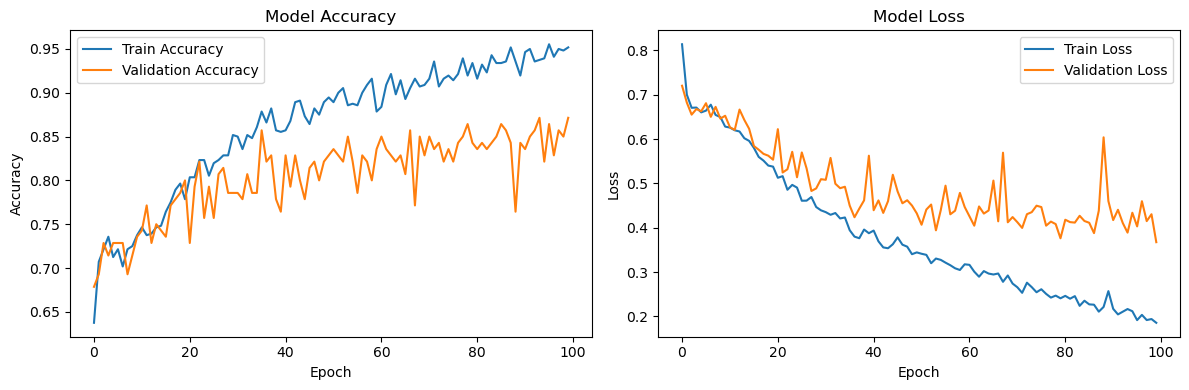

In [10]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='tanh', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='tanh'),
    tf.keras.layers.Dense(256, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100,validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100}%")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

# Loss plot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

This one seems to undergo significantly more noise than ReLU activation, although it looks like it hasn't quite peaked out yet. But it did take twice as many epochs and still wasn't as accurate as ReLU.

### Question 9: Too Small

c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6412 - loss: 0.8705 
Test Accuracy: 62.33333349227905%


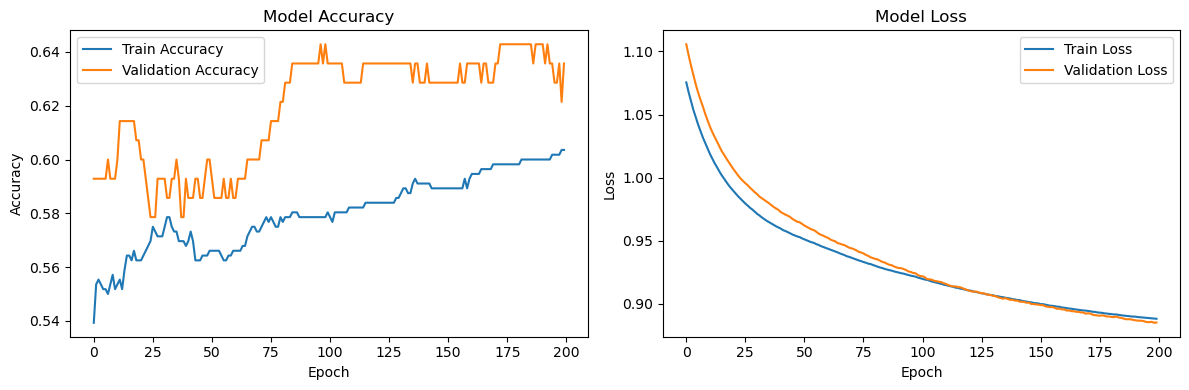

In [12]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='relu', input_shape = (X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200,validation_split=0.2,verbose = 0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100}%")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

# Loss plot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Woah! The plateaus on the validation set are so interesting. The loss is decreasing but seems to stop decreasing at a really high number.

### Question 10

c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443 (1.73 KB)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296 (1.16 KB)

None


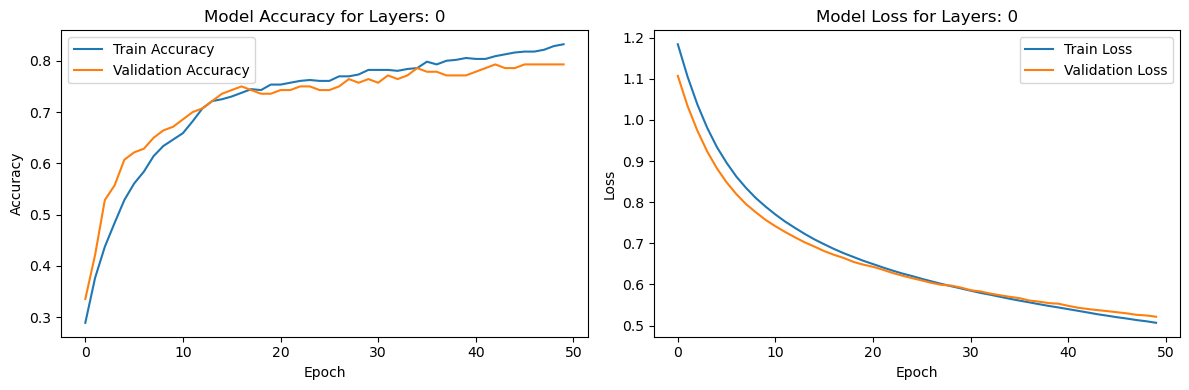

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.5538
Test Accuracy: 83.99999737739563%


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443 (1.73 KB)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296 (1.16 KB)

None


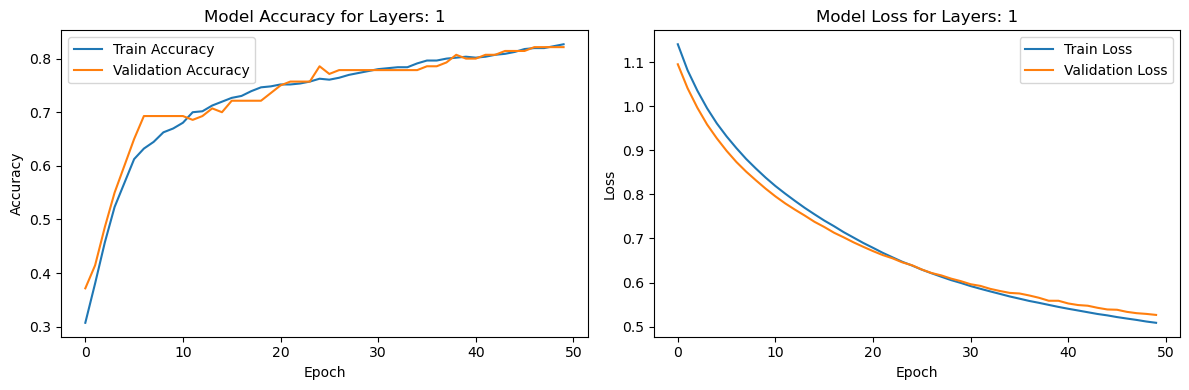

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8182 - loss: 0.5379
Test Accuracy: 82.99999833106995%


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259 (4.92 KB)

 Trainable params: 419 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 840 (3.29 KB)

None


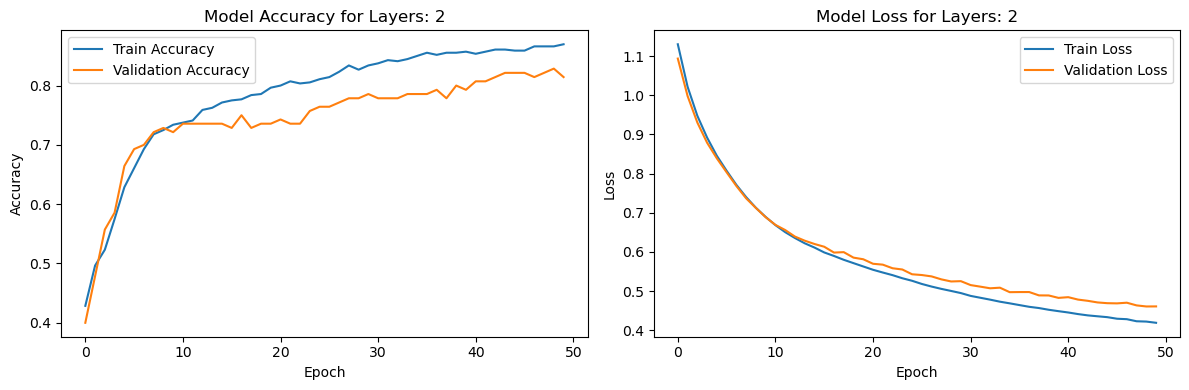

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8429 - loss: 0.4708
Test Accuracy: 86.00000143051147%


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,035 (11.86 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,024 (7.91 KB)

None


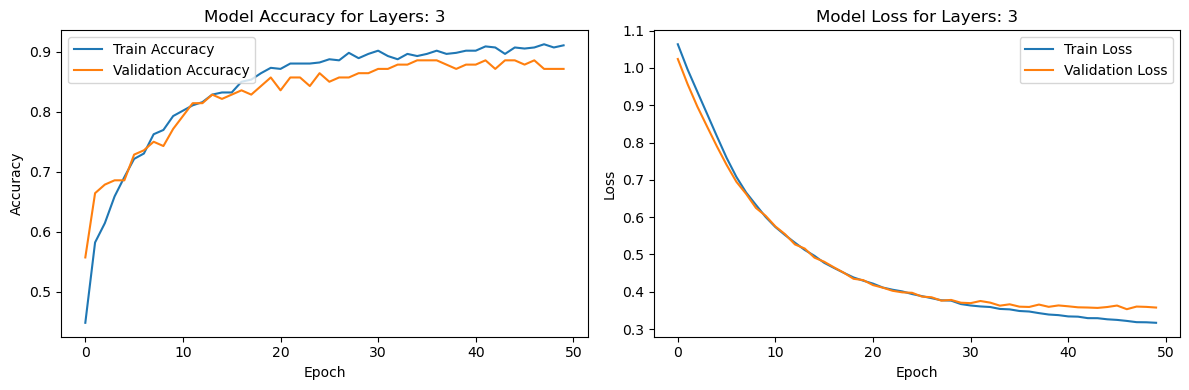

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9048 - loss: 0.3951
Test Accuracy: 90.66666960716248%


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,931 (30.98 KB)

 Trainable params: 2,643 (10.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,288 (20.66 KB)

None


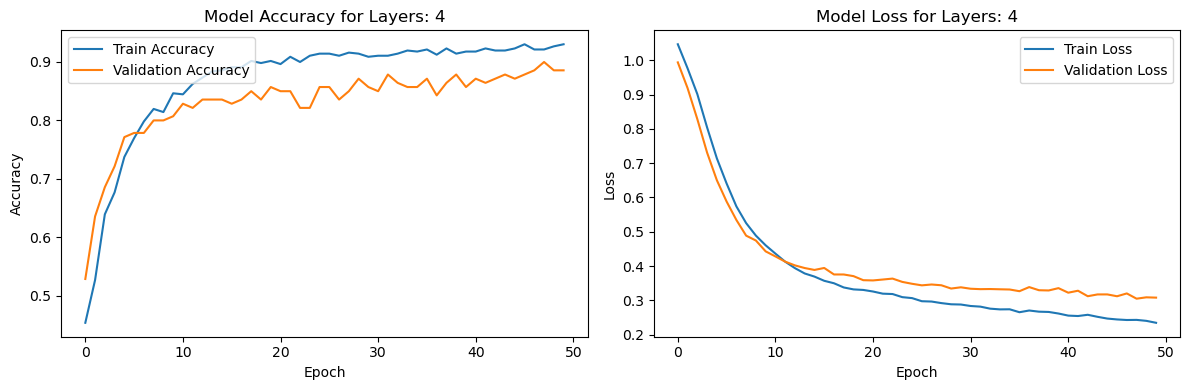

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8965 - loss: 0.4058
Test Accuracy: 89.66666460037231%


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,483 (68.30 KB)

 Trainable params: 5,827 (22.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,656 (45.54 KB)

None


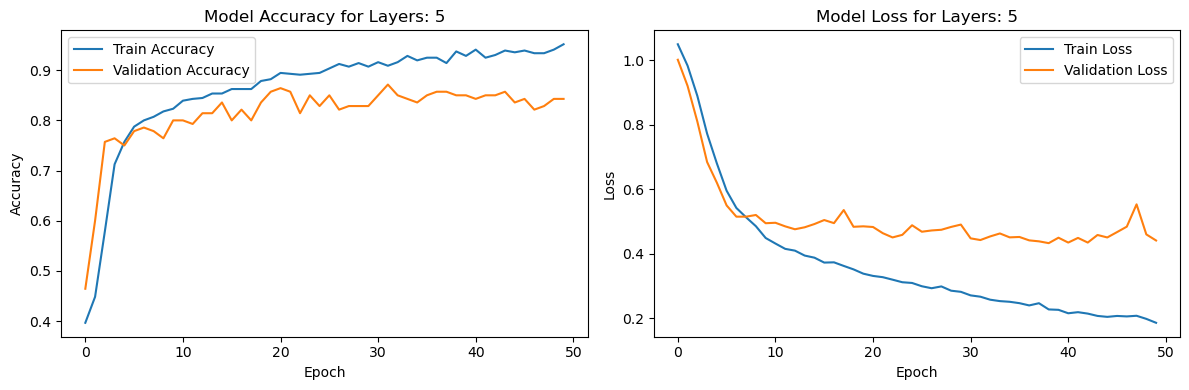

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8753 - loss: 0.4822
Test Accuracy: 89.33333158493042%


In [14]:
history_list = {}

num_hidden_layers = 6

for i in range(0,num_hidden_layers):
  # Define the model
  layers = [tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],))] # input layer
  if i > 0:
    layers = layers + [tf.keras.layers.Dense(16*n, activation='relu') for n in range(1,i)] # hidden layers
  layers = layers + [tf.keras.layers.Dense(3, activation='softmax')] # output layer
  model = tf.keras.Sequential(layers)

  # Compile the model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
                metrics=['accuracy'])

  # Train the model
  history = model.fit(X_train_scaled, y_train, epochs=50,validation_split=0.2,verbose = 0)

  print(model.summary())

  history_list[i] = history
  # Plotting
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))

  # Accuracy plot
  ax[0].plot(history.history['accuracy'], label='Train Accuracy')
  ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax[0].set_title('Model Accuracy for Layers: ' + str(i))
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(loc='upper left')

  # Loss plot
  ax[1].plot(history.history['loss'], label='Train Loss')
  ax[1].plot(history.history['val_loss'], label='Validation Loss')
  ax[1].set_title('Model Loss for Layers: ' + str(i))
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(loc='upper right')

  plt.tight_layout()
  plt.show()

  # Evaluate the model
  loss, accuracy = model.evaluate(X_test_scaled, y_test)
  print(f"Test Accuracy: {accuracy * 100}%")

Loss:

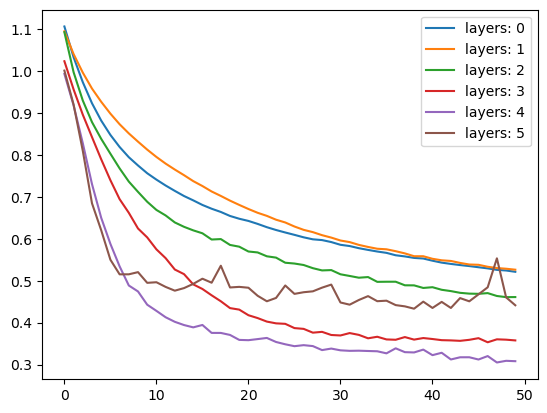

In [18]:
for i  in range(0, num_hidden_layers):
    plt.plot(history_list[i].history['val_loss'], label = 'layers: ' + str(i))
plt.legend()
plt.show()

Accuracy:

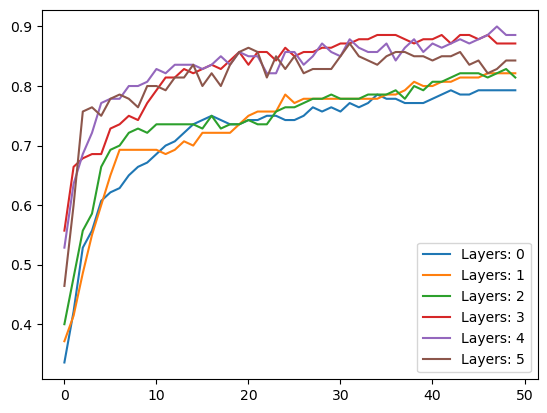

In [19]:
for i in range(0,num_hidden_layers):
  plt.plot(history_list[i].history['val_accuracy'], label='Layers: ' + str(i))
plt.legend()
plt.show()

### Question 11

In [20]:
# How the initializer is used in layers
initializer = tf.keras.initializers.Zeros()
layer = tf.keras.layers.Dense(3, kernel_initializer=initializer)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4328 - loss: 1.0498
Test Accuracy: 41.66666567325592%


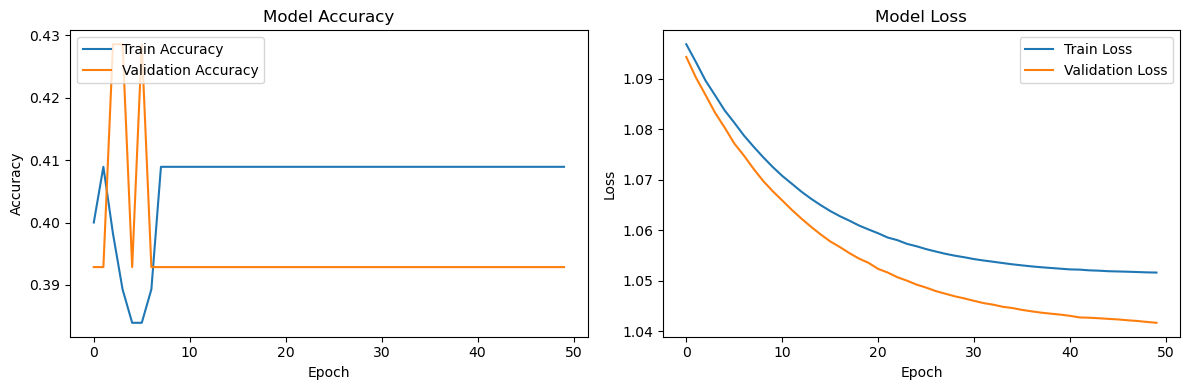

In [24]:
# Define the model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train_scaled.shape[1],), kernel_initializer=initializer,),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer),
    tf.keras.layers.Dense(3, activation='softmax', kernel_initializer=initializer),
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50,validation_split=0.2,verbose = 0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100}%")

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
ax[0].plot(history.history['accuracy'], label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper left')

# Loss plot
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

Woah! It doesn't like it at all!

## Extra Practice:

c:\Users\macik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_59 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

None


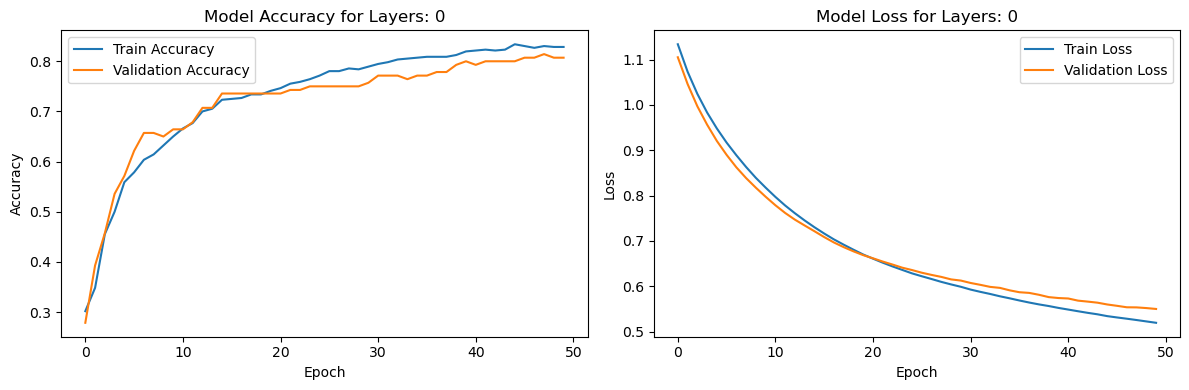

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7991 - loss: 0.5525
Test Accuracy: 81.99999928474426%


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147 (588.00 B)

 Trainable params: 147 (588.00 B)

 Non-trainable params: 0 (0.00 B)

None


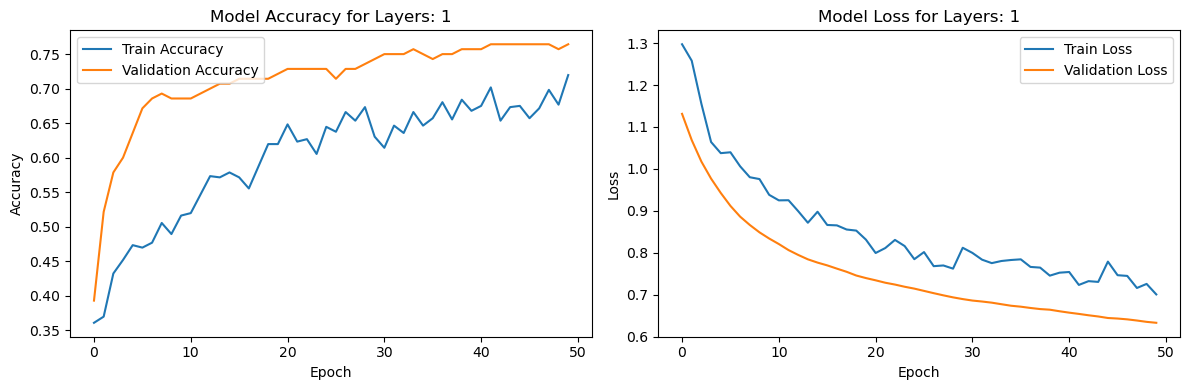

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7792 - loss: 0.6327
Test Accuracy: 80.0000011920929%


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419 (1.64 KB)

 Trainable params: 419 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

None


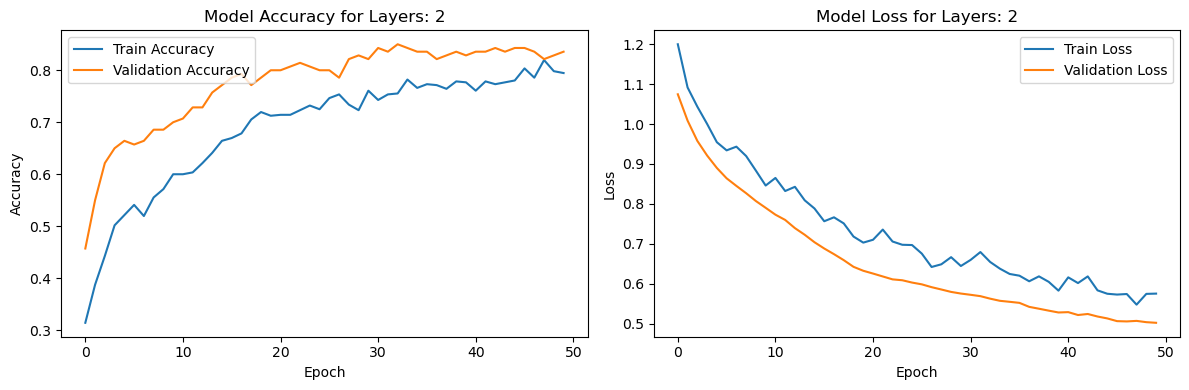

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8438 - loss: 0.4885
Test Accuracy: 86.33333444595337%


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,011 (3.95 KB)

 Trainable params: 1,011 (3.95 KB)

 Non-trainable params: 0 (0.00 B)

None


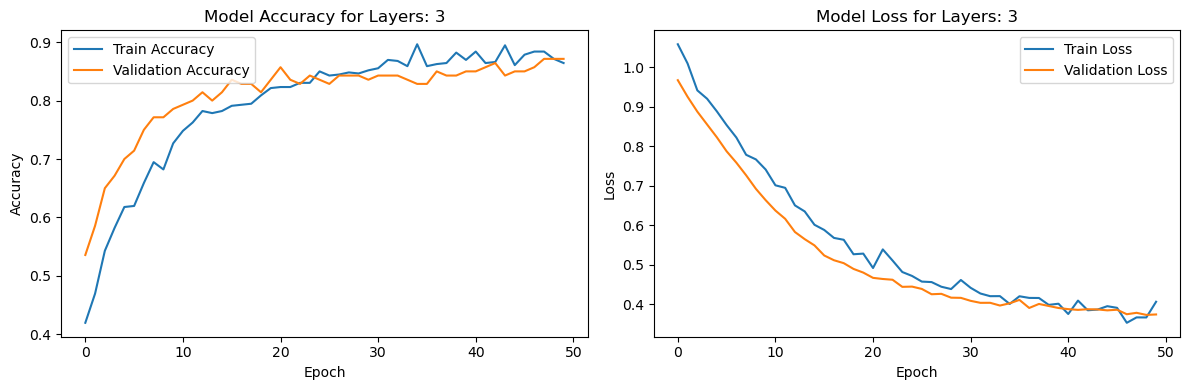

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8983 - loss: 0.3872
Test Accuracy: 90.3333306312561%


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 3)              │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,643 (10.32 KB)

 Trainable params: 2,643 (10.32 KB)

 Non-trainable params: 0 (0.00 B)

None


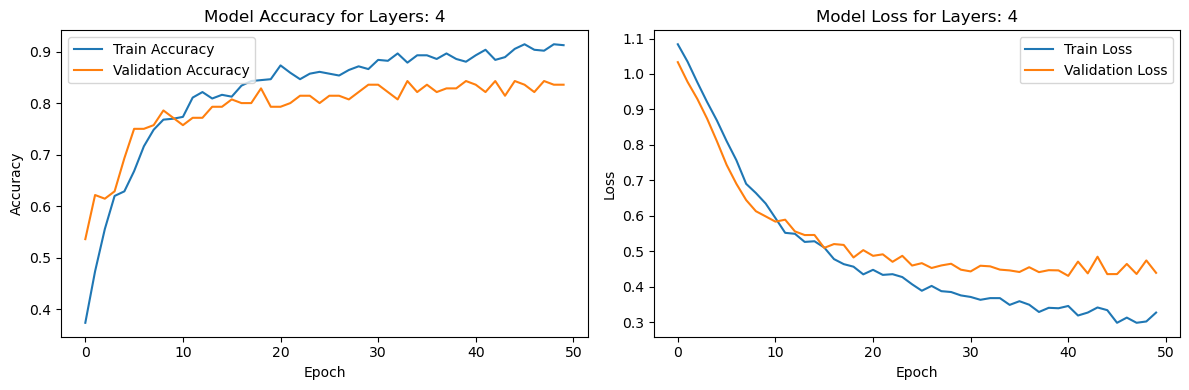

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8917 - loss: 0.4027
Test Accuracy: 89.99999761581421%


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 48)             │         1,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,827 (22.76 KB)

 Trainable params: 5,827 (22.76 KB)

 Non-trainable params: 0 (0.00 B)

None


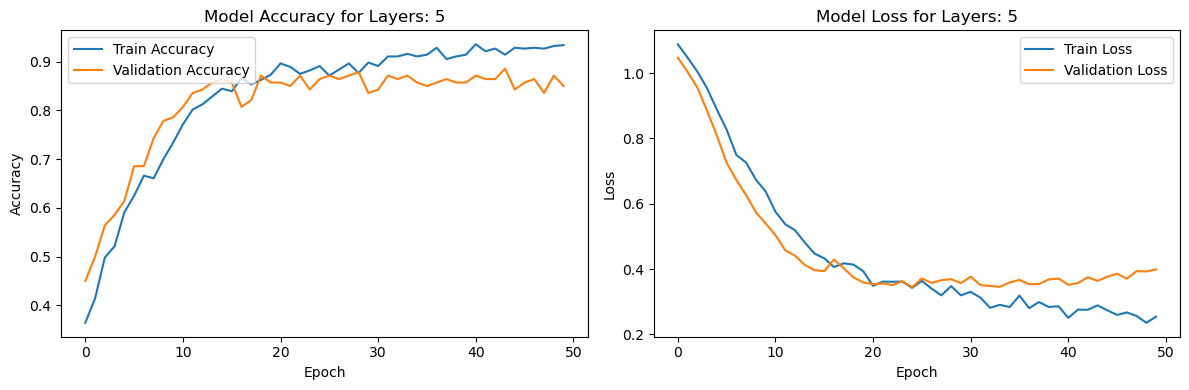

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8588 - loss: 0.5010
Test Accuracy: 87.66666650772095%


In [26]:
# Hint refer the Question - 11 code and add Dropout layer after each dense layer.
history_list = {}

num_hidden_layers = 6 # Use 6 for optimal reference.

for i in range(0,num_hidden_layers):
  # Define the model

  layers = [tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],))] # input layer
  if i > 0:
    layers = layers + [tf.keras.layers.Dense(16*n, activation='relu') for n in range(1,i)] # hidden layers
    layers = layers + [tf.keras.layers.Dropout(0.5)] # dropout layers are added for regularization # Use 0.5 probability
  layers = layers + [tf.keras.layers.Dense(3, activation='softmax')] # output layer
  model = tf.keras.Sequential(layers)

  # Compile the model
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',  # Changed to sparse_categorical_crossentropy
                metrics=['accuracy'])

  print(model.summary())

  # Train the model
  history = model.fit(X_train_scaled, y_train, epochs=50,validation_split=0.2,verbose = 0)

  history_list[i] = history
  # Plotting
  fig, ax = plt.subplots(1, 2, figsize=(12, 4))

  # Accuracy plot
  ax[0].plot(history.history['accuracy'], label='Train Accuracy')
  ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax[0].set_title('Model Accuracy for Layers: ' + str(i))
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(loc='upper left')

  # Loss plot
  ax[1].plot(history.history['loss'], label='Train Loss')
  ax[1].plot(history.history['val_loss'], label='Validation Loss')
  ax[1].set_title('Model Loss for Layers: ' + str(i))
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(loc='upper right')

  plt.tight_layout()
  plt.show()

  # Evaluate the model
  loss, accuracy = model.evaluate(X_test_scaled, y_test)
  print(f"Test Accuracy: {accuracy * 100}%")